In [1]:
import os, sys
import numpy as np
import pydicom
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import h5py
import sigpy
from sigpy.mri.samp import poisson
import torch
from torch.fft import ifftn

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.data_io import load_h5, load_output, save_output, \
                            expmt_already_generated
from utils.transform import np_to_tt, split_complex_vals, recon_ksp_to_img, ifft_2d
from utils.helpers import num_params, get_masks
from include.decoder_conv import init_convdecoder
from include.mri_helpers import data_consistency
from include.fit import fit
from utils.evaluate import calc_metrics

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    torch.cuda.set_device(1)
    
from utils.transform import np_to_tt, np_to_var, ifft_2d, fft_2d, root_sum_squares, \
                        reshape_complex_channels_to_sep_dimn, \
                        reshape_complex_channels_to_be_adj, \
                        split_complex_vals, recon_ksp_to_img, \
                        fftshift, ifftshift, is_complex, reshape_adj_channels_to_be_complex

In [2]:
def plot_list(arr_list):
    
    NUM_COLS = len(arr_list)
    title_list = ['gt', 'est', 'dc']
    
    fig = plt.figure(figsize=(10,10))
    
    for idx in range(NUM_COLS):
        ax = fig.add_subplot(1,NUM_COLS,idx+1)
        ax.imshow(arr_list[idx], cmap='gray')
        ax.set_title(title_list[idx])
        ax.axis('off')

In [3]:
path = '/bmrNAS/people/arjun/data/qdess_knee_2020/files_recon_calib-16/'
files = [f for f in listdir(path) if isfile(join(path, f))]
files.sort()

print(len(files))

164


##### data format
- 'kspace': Nx x Ny x Nz x # echos x # coils
- 'maps': Nx x Ny x Nz x # coils x # maps
- 'target': Nx x Ny x Nz x # echos x # maps

take kspace, run on one echo. what to do w num coils? recon all, then rss at end

### load data, make mask

In [4]:
dtype = torch.cuda.FloatTensor

In [6]:
fn = files[0]
f = h5py.File(path + fn, 'r')

# ksp = torch.from_numpy(f['kspace'][()])
# targ = torch.from_numpy(f['target'][()])
ksp = torch.from_numpy(np.load('ksp_3d_samp.npy'))

# get echo1, reshape to be (nc, kx, ky, kz)
ksp_vol = ksp[:,:,:,0,:].permute(3,0,1,2)
ksp_vol.shape

torch.Size([16, 512, 512, 160])

In [51]:
# mask = poisson(img_shape=(512, 160), accel=4)
# mask = abs(mask)
# np.save('mask_3d.npy', mask)
mask = torch.from_numpy(np.load('mask_3d.npy').astype('float32'))
mask.shape

torch.Size([512, 160])

# TODO: decide how to emphasize low freq components

### force central `CxC` pixels in mask to be 1 

In [41]:
# idx_y, idx_z = mask.shape[0] // 2, mask.shape[1] // 2
# C = 25
# mask[idx_y-C:idx_y+C, idx_z-C:idx_z+C] = 1

### get central slice in kx of volumes
because dd+ requires a 2d recon, and we're undersampling in ky, kz

note
- use scaled version of `ksp_orig` for fitting the network
- use original version of `ksp_orig` for dc step 

In [52]:
idx_kx = ksp_vol.shape[1] // 2
ksp_orig = ksp_vol[:, idx_kx, :, :]

### initialize network

network has same num_params as original network w lone difference of 32 = 2 * n_c output channels instead of 30. hence as written now, network is agnostic to number of pixels in a slice, e.g. 512x512 would have same num_params as 512x160 -- is this right?

In [53]:
# slice_ksp (nc, x, y) in original. now slice_ksp (nc, y, z)
# mask is mask2d is (x,y) in original. now (y,z)
net, net_input, ksp_orig_ = init_convdecoder(ksp_orig, mask)

# from utils.helpers import num_params
# params = [p.shape for p in net.parameters()]
# params

### apply mask
currently a modified version of the function call `ksp_masked, img_masked = get_masked_measurements(vol_ksp, mask_)` which has a bunch of data shape conversion nonsense

In [54]:
# ksp_masked = ksp_orig * mask
ksp_masked = ksp_orig_ * mask
img_masked = ifft_2d(ksp_masked)

ksp_orig.shape, ksp_masked.shape, img_masked.shape

(torch.Size([16, 512, 160]),
 torch.Size([16, 512, 160]),
 torch.Size([16, 512, 160]))

### TODO: make new data format work for fastmri

### run network

In [55]:
# want img_masked, ksp_masked to be complex tensors shape [nc,x,y]
net, mse_wrt_ksp, mse_wrt_img = fit(
        ksp_masked=ksp_masked, img_masked=img_masked,
        net=net, net_input=net_input, mask2d=mask, num_iter=1000)

# big difference when using unscaled v scaled version of ksp for dc step

comparing ksp_orig_ (scaled) vs ksp_orig (unscaled)
- when ksp_est = 0, get same output w either
- when ksp_est = fft_2d(img_out)...
    - ksp_orig yields the same recon as above
    - ksp_orig_ yields a crap recon

In [56]:
def norm(arr):
    return torch.linalg.norm(abs(arr))

In [57]:
img_out = net(net_input.type(dtype))[0]

# make complex tensor [nc,x,y] from [2*nc,x,y]
img_out = reshape_adj_channels_to_be_complex(img_out)

ksp_est = fft_2d(img_out)
# ksp_est = torch.zeros((16,512,160),dtype=torch.complex64)

# apply dc step using 3d boolean mask
mask_3d_bool = mask.expand(ksp_orig.shape).type(torch.bool)
ksp_dc = torch.where(mask_3d_bool, ksp_orig_, ksp_est) # arg 2 either ksp_orig_ (scaled) or ksp_orig (non-scaled)

### create images from k-space

In [58]:
img_est = root_sum_squares(ifft_2d(ksp_est)).detach().numpy()

img_dc = root_sum_squares(ifft_2d(ksp_dc)).detach().numpy()

img_gt = root_sum_squares(ifft_2d(ksp_orig))

### recon w sampling 25x25 center square, num_iter=1000

# TODO: why is `img_est` mirror/flipped?!
- ONLY happens when i force central square mask to be 1
- ideas to approach this...
    - sanity check code, i.e. that nothing weird is happening when i make center piece / apply mask
        - try just doing ifft(ksp_orig * mask) when mask has central square 1's
        - if that looks good, could this be happening within the network processing? seems unlikely
    - read up on how poisson disc sampling works in mri
        - how do they emphasize low frequency components?
        - https://era.ed.ac.uk/bitstream/handle/1842/18759/20160817_Workshop_Benjamin.pdf?sequence=1

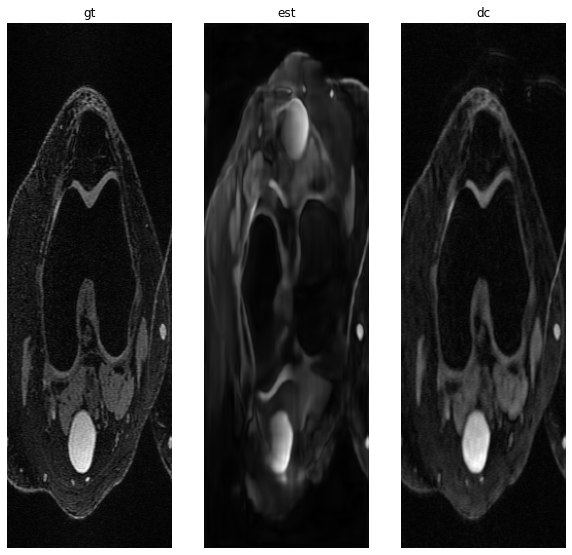

In [49]:
plot_list([img_gt, img_est, img_dc])

### recon w sampling 15x15 center square, num_iter=1000

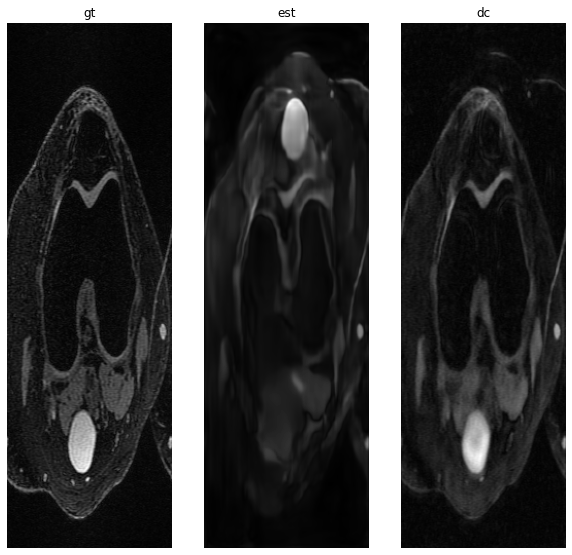

In [39]:
plot_list([img_gt, img_est, img_dc])

### recon w sampling 15x15 square center and `ksp_est=0`, num_iter = N/A

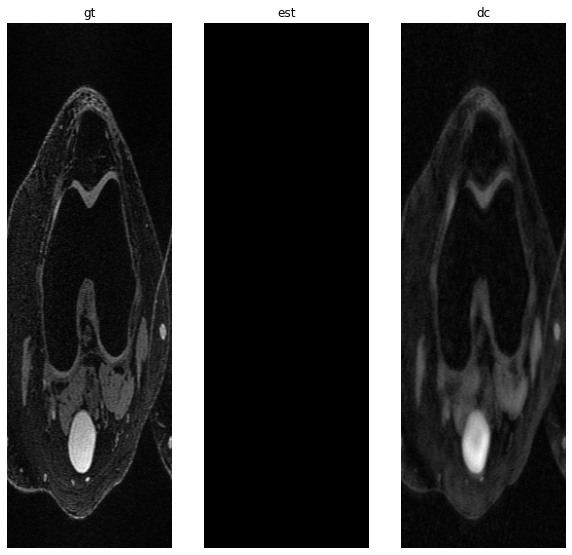

In [36]:
plot_list([img_gt, img_est, img_dc])

### recon w sampling 0x0 center square, num_iter=1000

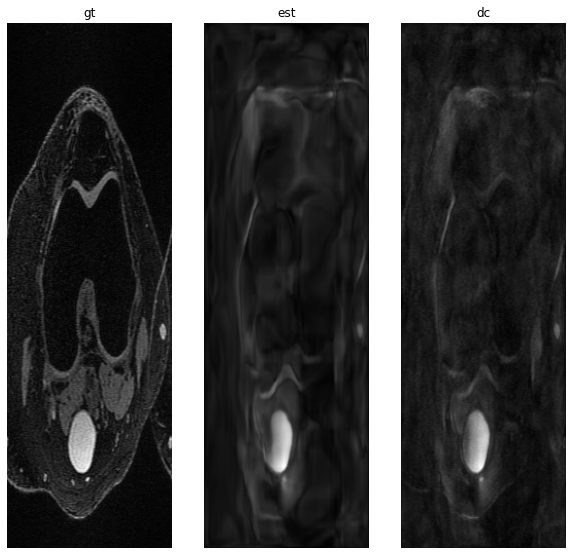

In [24]:
plot_list([img_gt, img_est, img_dc])

### recon w sampling 0x0 center square and `ksp_est=0`, num_iter = N/A

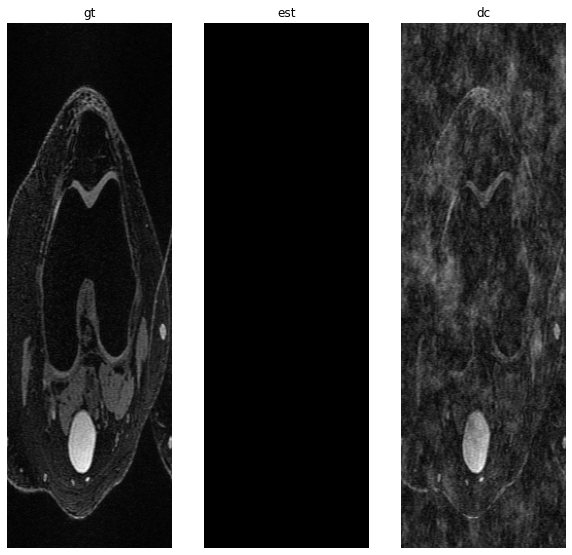

In [39]:
plot_list([img_gt, img_est, img_dc])